Mental Health Classification Project

In [20]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch

label_map = {
    "Normal": 0,
    "Depression": 1,
    "Suicidal": 2,
    "Anxiety": 3,
    "Stress": 4,
    "Bipolar": 5,
    "Personality Disorder": 6
}


db = pd.read_csv('Sentiment_analysis_dataset(in).csv')


In [21]:
print("Unique labels in dataset:", db['Status'].unique())


Unique labels in dataset: ['Depression' 'Stress' 'Normal' 'Suicidal' 'Anxiety'
 'Personality disorder' 'Bipolar' nan]


In [22]:
db = db.dropna(subset=['Statement', 'Status'])
db['Status'] = db['Status'].str.strip().str.title()
db['Statement'] = db['Statement'].apply(lambda x: x.lower())
unmapped = set(db['Status'].unique()) - set(label_map.keys())
if unmapped:
    print("Warning: These labels aren't in your map:", unmapped)
    db = db[db['Status'].isin(label_map.keys())]

statement = db['Statement'].tolist()
status = db['Status'].tolist()

print(db.head(20))

                                            Statement      Status
0   life doesn’t feel worth it that’s kind of it? ...  Depression
1   this life sucks and if it were for my religiou...  Depression
2   its been 9 months now for our marriage and she...      Stress
3   i do not feel particularly sad or anxious or a...  Depression
4   i am taking venlafaxine. it is an ssri. does n...  Depression
5   i (17m) have come to the realisation that my d...  Depression
6   been on fluoxetine for year but anyway there s...  Depression
7   even a four day week seems too long i want to ...      Normal
8   i often had suicidal thoughts, recently, with ...    Suicidal
9   this is the first time facing pisces. extro pa...      Normal
10  being an orphan at your early stages of life b...  Depression
11  the dread of thinking you have cancer... again...     Anxiety
12  i (30f) married my husband (31m) about 6 month...      Stress
13           what day is eid al-fitr if you may know?      Normal
14  free c

In [24]:
train_label_counts = train_labels.value_counts().sort_index()
total = train_label_counts.sum()
class_weights = [total / train_label_counts[lbl] for lbl in label_map.keys()]
print("Class Weights:", class_weights)


Class Weights: [np.float64(3.232876712328767), np.float64(3.41316672451695), np.float64(4.895453036840358), np.float64(13.746505125815471), np.float64(20.26098901098901), np.float64(19.407894736842106), np.float64(50.513698630136986)]


In [26]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # 👈 accepts any extra arguments
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        weight = torch.tensor([
            3.23, 3.41, 4.89, 13.75, 20.26, 19.41, 50.51  # whatever your final class weights are
        ], dtype=torch.float32).to(logits.device)

        loss_fct = CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [23]:
train_texts, val_texts, train_labels, val_labels = train_test_split(db['Statement'], db['Status'], test_size=0.2, random_state=42)

train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

print(f"training data size: {len(train_texts)}")
print(f"Testing data size: {len(val_texts)}")

training data size: 29500
Testing data size: 7375


In [27]:
print("Training label distribution:\n", train_labels.value_counts())
print("\nValidation label distribution:\n", val_labels.value_counts())


Training label distribution:
 Status
Normal                  9125
Depression              8643
Suicidal                6026
Anxiety                 2146
Bipolar                 1520
Stress                  1456
Personality Disorder     584
Name: count, dtype: int64

Validation label distribution:
 Status
Normal                  2315
Depression              2140
Suicidal                1429
Anxiety                  545
Bipolar                  421
Stress                   353
Personality Disorder     172
Name: count, dtype: int64


In [28]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Make sure the texts are strings
train_texts = train_texts.astype(str).tolist()
val_texts = val_texts.astype(str).tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Debug print
print("train_texts type:", type(train_texts))         # should be list
print("train_texts[0] type:", type(train_texts[0]))   # should be str



train_texts type: <class 'list'>
train_texts[0] type: <class 'str'>


In [29]:
print(train_texts[:5])



['i want everyone to feel my pain i am sick of everyone trying to hold me down and take advantage of mei amsick of always being second choicei amsick of being neglected feared and hated i want everyone to feel my wrath and my pain i am sick of hiding in the shadows and just taking it all i want everything they ever did to me to happen to them and 100 times over i hope they never get reliefi amsick of people and i am not afraid to admit it and it makes me sick to see so many happy people with perfect lives they dont deserve it if i cant be happy why should anyone else be', 'home. had uni today, got results back :hd, yehhh! its been 3 yrs, why am i always thinking of the wat ifs?', 'really? why?', 'i am not sure how much longer i can last. i always was a fighter but i think the straw has broken the camels back. where do i go from here? i think its getting close to that time for me to make the decision. the trauma is too great. people fucking suck. and i cannot burden these feelings on my

In [31]:
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, label_map):
        self.encodings = encodings
        self.labels = labels
        self.label_map = label_map

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label = self.labels.iloc[idx]
        #item["labels"] = torch.tensor(self.label_map[idx])
        item["labels"] = torch.tensor(self.label_map[label])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MentalHealthDataset(train_encodings, train_labels, label_map)
val_dataset = MentalHealthDataset(val_encodings, val_labels, label_map)

In [33]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels = 7)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
    output_dir="./results",                       # Where to save model checkpoints
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",                  # <--- Corrected!
    save_strategy="epoch",                        # Save model at end of each epoch
    logging_strategy="epoch",                     # Log metrics at end of each epoch
    learning_rate=2e-5,                           # Good default for RoBERTa
    weight_decay=0.01,                            # Slight regularization
    load_best_model_at_end=True,                  # Load the best model (based on eval loss)
    metric_for_best_model="accuracy",             # If using compute_metrics (below)
    save_total_limit=2,                           # Keep only 2 checkpoints to save space
    logging_dir="./logs",
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [37]:
#trainer.train(resume_from_checkpoint=True)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.725800,0.568571,0.827797,0.828612


KeyboardInterrupt: 

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [127]:
model_path = "./model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
trainer.save_state()


In [16]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [15]:
import torch

def predict_label(text, model, tokenizer, label_map):
    id2label = {v: k for k, v in label_map.items()}  # safe reverse map
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    predicted_label_id = torch.argmax(probs, dim=1).item()
    label_name = id2label[predicted_label_id]  # ← safe lookup

    return label_name, probs.detach().numpy()

In [131]:
test_statements = [
    "I am so stressed out and tired. I'm so done",
    "Life is so empty and hopeless",
    "I'm fine. Nice weather today!",
    "I have so much homework I'm gonna fail my class.",
    "My dog died. Life has become dull and I'm really sad.",
    "I'm always mad or sad what the hell.",
    "sometimes i hear voices and they confuse me",
    "I'm depressed",
    "I'm anxious"
]

for text in test_statements:
    label, _ = predict_label(text, model, tokenizer, label_map)
    print(f"Input: {text}")
    print(f"Predicted Label: {label}")
    print("---")

Input: I am so stressed out and tired. I'm so done
Predicted Label: Bipolar
---
Input: Life is so empty and hopeless
Predicted Label: Personality Disorder
---
Input: I'm fine. Nice weather today!
Predicted Label: Personality Disorder
---
Input: I have so much homework I'm gonna fail my class.
Predicted Label: Personality Disorder
---
Input: My dog died. Life has become dull and I'm really sad.
Predicted Label: Bipolar
---
Input: I'm always mad or sad what the hell.
Predicted Label: Personality Disorder
---
Input: sometimes i hear voices and they confuse me
Predicted Label: Personality Disorder
---
Input: I'm depressed
Predicted Label: Bipolar
---
Input: I'm anxious
Predicted Label: Personality Disorder
---


In [ ]:
trainer.evaluate()

KeyboardInterrupt: 

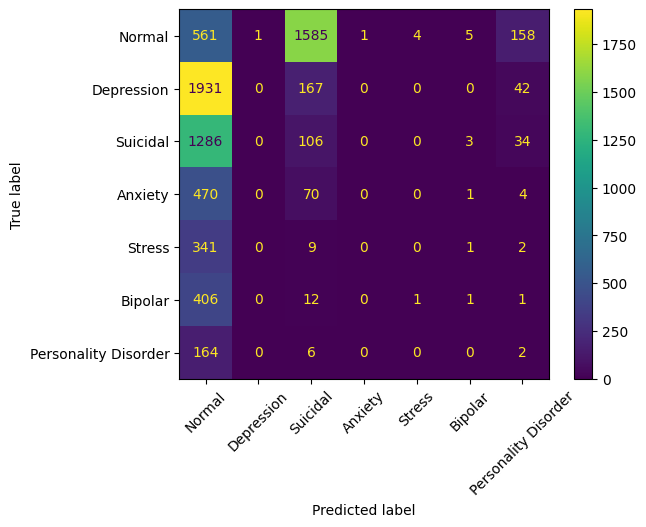

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(val_dataset)

y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(xticks_rotation=45)
